Computational Magnetic Resonance Imaging (CMRI) 2023/2024 Winter semester

- Author          : Jinho Kim
- Email           : <jinho.kim@fau.de>
- Last update     : Oct. 06. 2023

# Lab02: k-space sampling and Fourier reconstruction
## Import packages

In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift, ifft2, fft2
from skimage.filters import window
import matplotlib.pyplot as plt

## 1. FFT Reconstruction of Cartesian MRI Data:
- Load the file `kdata1.mat`.

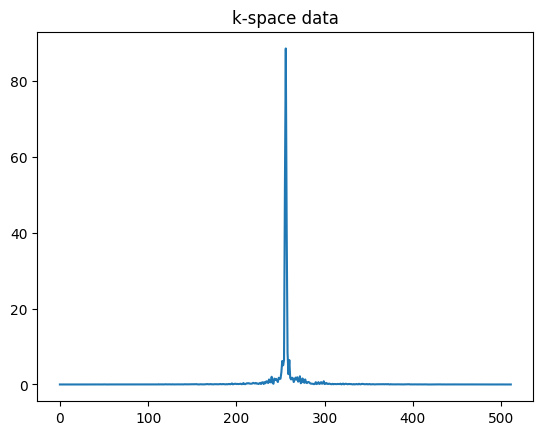

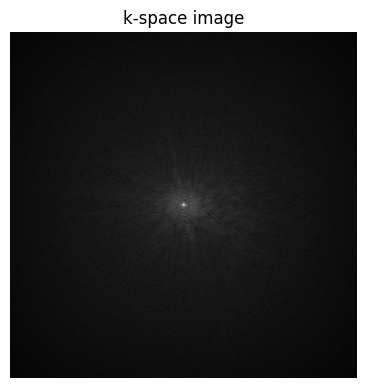

In [2]:
mat = utils.load_data('kdata1.mat')
kdata = mat['kdata1']  #kdata label to get k-space image
# only see dot in the origin because 0 frequency has a large coefficient
# norm = 0.3, 0 frequency has large intensity than others
plt.plot(abs(kdata[256, :]))
plt.title("k-space data")
utils.imshow([kdata], titles=["k-space image"], norm=0.3)
# the signal has values only at the "zero-freq", but this image is somehow "zero-centered"
# and the plot, or the numpy.fft is assume origin is at the left

- Reconstruct `kdata1` using FFT (create functions `fft2c` and `ifft2c` to perform forward and inverse Fourier transforms for MRI data as described in class, see `numpy.fft` Python module).
  - Define fft2c and ifft2c functions

In [3]:
# Multiplication and division by np.sqrt(np.size(x)) is to ensure that the forward and inverse transforms maintain the same energy in the signal.
# numpy.fft assume the origin at the top left, but in the image, the 0 freq is at the center
# shift the low freq. to the left
# fft shift -> fft2 -> ifft shift -> normalization (important)
# image domain and freq domain have the same energy
# The output, analogously to fft, contains the term for zero frequency in the low-order corner of the transformed axes, 
#the positive frequency terms in the first half of these axes, 
#the term for the Nyquist frequency in the middle of the axes and the negative frequency terms in the second half of the axes, 
#in order of decreasingly negative frequency.
def fft2c(x, axes=(-2, -1)):
    # Your code here ...
    # fftshift: shift the DC component to the center
    ffted = fftshift(fft2(ifftshift(x, axes=axes), axes=axes), axes=axes) / np.sqrt(np.size(x))
    return ffted


def ifft2c(x, axes=(-2, -1)):
    # Your code here ...
    iffted = ifftshift(ifft2(fftshift(x, axes=axes), axes=axes), axes=axes) * np.sqrt(np.size(x))
    return iffted

Reconstructe kdata using ifft2c function


- Plot the magnitude and phase of the reconstructed image.

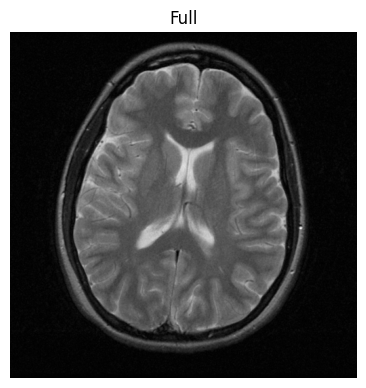

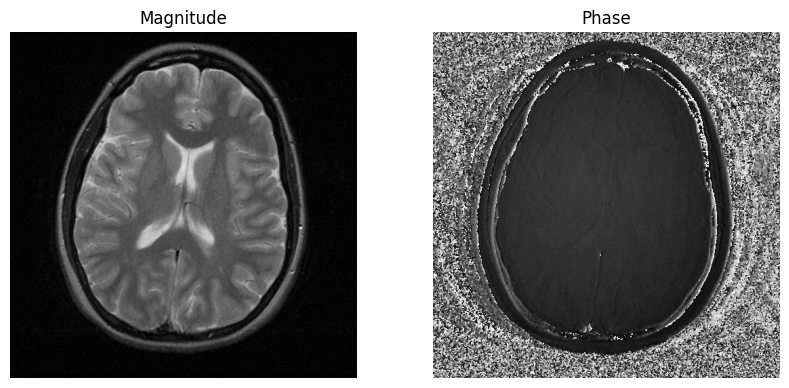

In [4]:
# Your code here ...
recon_img = ifft2c(kdata)
utils.imshow([recon_img], titles=["Full"])
utils.imshow([np.abs(recon_img), np.angle(recon_img)], titles=["Magnitude", "Phase"], is_mag=False)

## 2. Effects of k-space Zero-padding and Truncation:

- Truncate `kdata1` by taking the central 64×64, 128×128, and 256×256 k-space points. Then, Zero-pad to 512×512

Define truncate function



In [5]:
def get_filter(kspace: np.ndarray, size:int, type:str):
    '''
    This function returns the [type] mask filter of size
    
    @param:
        kspace:         k-space data. (shape of [N, N])
        size:           size of the filter. (int)
        type:           type of the filter. (str)
    @return:
        frame:          filter. (shape of [N, N])
    '''
    # Your code here ...
    # centers are set to 1, outside is 0 -> low pass filters (rectangle / hamming filters)
    # rectangle filter
    frame = np.zeros_like(kspace)
    mask = np.ones([size, size]) if type == "Rectangle" else window("hamm", [size, size])
    frame_size = kspace.shape[0]
    
    x, y = ((frame_size - size) // 2), (frame_size + size) // 2
    frame[x:y, x:y] = mask
    
    return frame

def masking(kspace: np.ndarray, size:int, type:str):
    '''
    This function masks the ksapce out using the [type] mask by size

    @param:
        kspace:         k-space data. (shape of [N, N])
        size:           size of the filter. (int)   
        type:           type of the filter. (str)
    @return:
        masked:         masked k-space data. (shape of [N, N])
    '''
    # Your code here ...
    # get filter of k-space
    mask = get_filter(kspace, size, type)
    masked = kspace * mask # multiplication in k-space == convolution in image domain, applied PSF
    
    return masked

Truncate kdata1 to 64x64, 128x128, and 256x256

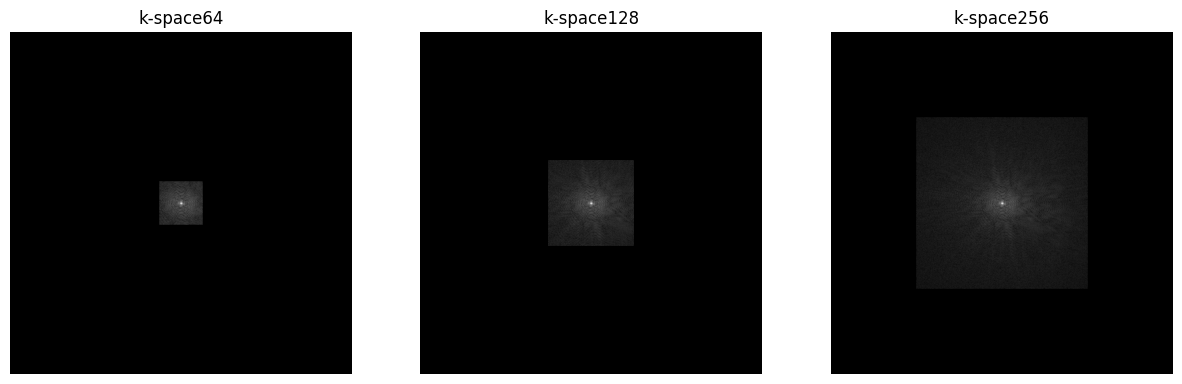

In [6]:
# Your code here ...
kdata64 = masking(kdata, 64, "Rectangle")
kdata128 = masking(kdata, 128, "Rectangle")
kdata256 = masking(kdata, 256, "Rectangle")

utils.imshow([kdata64, kdata128, kdata256], titles=["k-space64", "k-space128", "k-space256"], norm=0.3)
# smaller size kernel will lead to more blurred image

- reconstruct the corresponding images.


In [7]:
# Your code here ...
recon_img64 = ifft2c(kdata64)
recon_img128 = ifft2c(kdata128)
recon_img256 = ifft2c(kdata256)


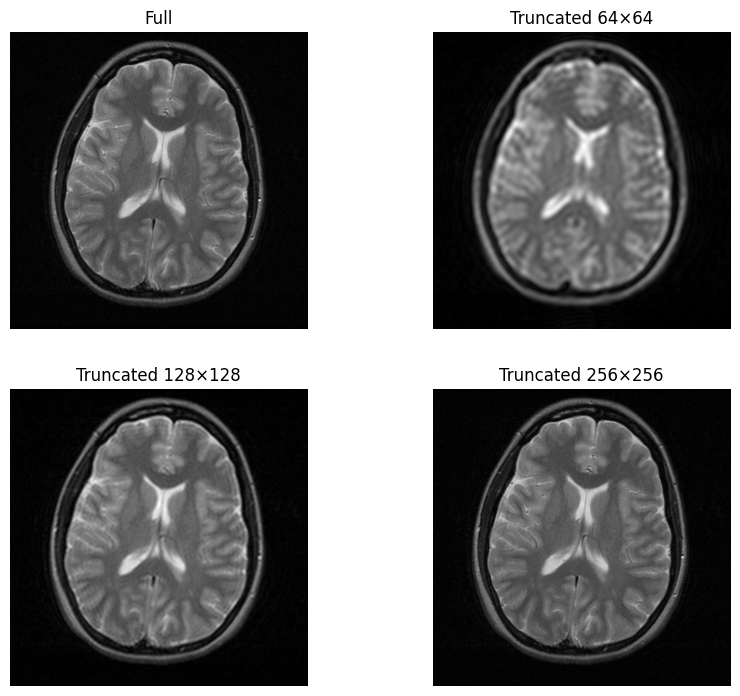

In [8]:
# Your code here ...
# 64 truncated: gibbs ringing artifacts: intensity gaps between pixels
# get more elements in the middle, the image get clear / sharper
utils.imshow([abs(recon_img), abs(recon_img64), abs(recon_img128), abs(recon_img256)], ["Full", "Truncated 64×64", "Truncated 128×128", "Truncated 256×256"], is_mag=False, num_rows=2)


- Discuss the effects of k-space truncation.

## 3. Point Spread Function (PSF):
- Details about PSF will be explained in the exercise.
- Compute the (1D) PSF along the x dimension for each k-space truncation pattern in part 2.

Define psf function

In [9]:
def get_psf(size: list, type):
    '''
    This function returns the point spread function.
    
    @param:
        size:           size of the filter. (list[shape of kspace, shape of mask]])
        type:           type of the filter. (str)
    @return:
        psf:            point spread function. (shape of [N, N])
    
    '''
    # Your code here ...
    frame_size, mask_size = size
    frame = np.zeros(frame_size)
    mask = np.ones(mask_size) if type == "Rectangle" else np.hamming(mask_size)
    x, y = (frame_size - mask_size) // 2, (frame_size + mask_size) // 2
    frame[x:y] = mask
    psf = abs(ifft2c(frame[:, None]).squeeze(1))
    
    return psf

Get PSF for each k-space truncation pattern

In [10]:
# Your code here ...
# point spread out, and get blurring
# PSF is the respond of 
# PSF is wide enough -> bluring, narrow -> bluring reduced, keep the sharpness
psf64 = get_psf([kdata64.shape[0], 64], "Rectangle")
psf128 = get_psf([kdata128.shape[0], 128], "Rectangle")
psf256 = get_psf([kdata256.shape[0], 256], "Rectangle")

#utils.imshow([psf64, psf128, psf256], titles=["psf64", "psf128", "psf256"])
# PSF of different length

- Plot the different PSFs in the same figure using different colors.


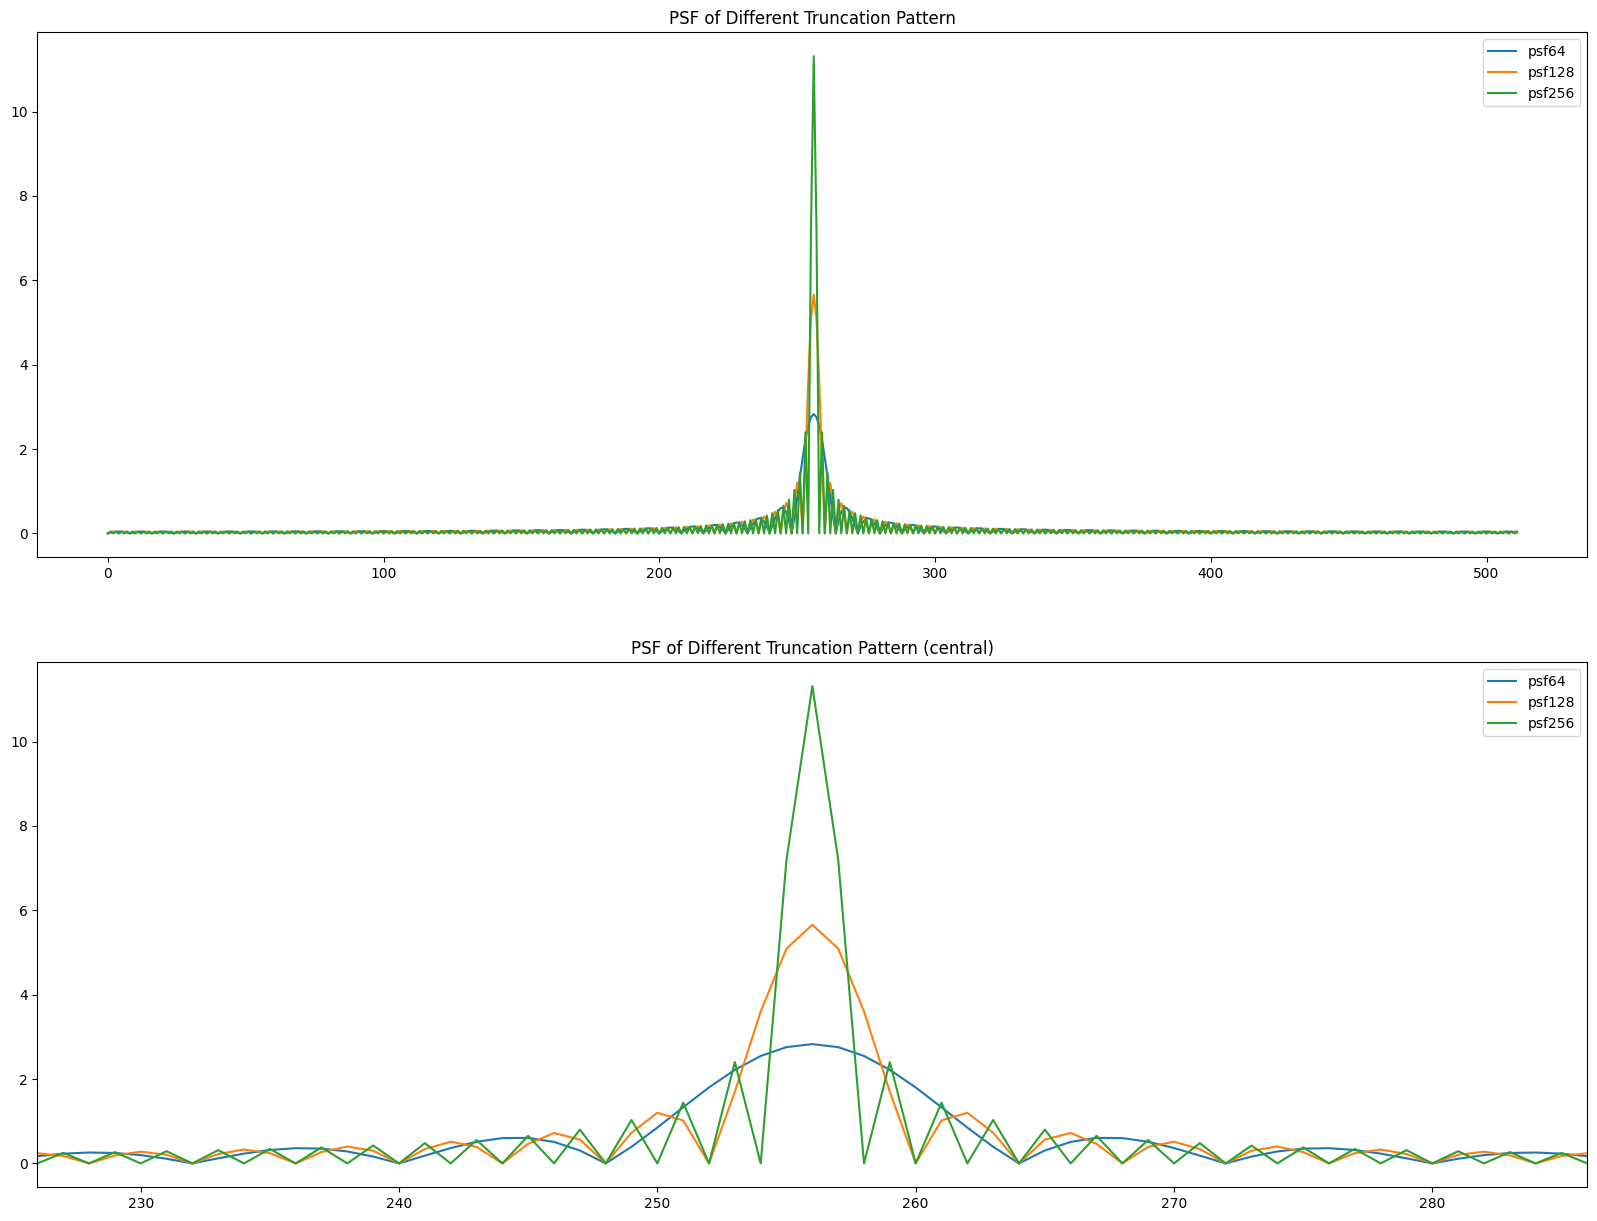

In [11]:
# Your code here ...
plt.subplot(211)
for psf, label in zip([psf64, psf128, psf256], ["psf64", "psf128", "psf256"]):
    plt.plot(psf, label=label)
plt.legend()
plt.title("PSF of Different Truncation Pattern")

plt.subplot(212)
for psf, label in zip([psf64, psf128, psf256], ["psf64", "psf128", "psf256"]):
    plt.plot(psf, label=label)
plt.legend()
plt.xlim(256 - 30, 256 + 30)
plt.title("PSF of Different Truncation Pattern (central)")

figure = plt.gcf()
figure.set_size_inches(20, 15)
plt.show()


- Compute the full-width at half-maximum (FWHM) for each PSF.
  
  
Define get_fwhm function


In [12]:
def get_fwhm(psf: np.ndarray):
    '''
    This function calculates the Full Width Half Maximum of the given point spread function.

    @param:
        psf:            1D point spread function. (shape of [N])
    @return:
        fwhm:           Full Width Half Maximum. (int)
    '''
    # Your code here ...
    signal_len = len(psf)
    psf_shift = psf - np.max(psf) / 2 # half maximum is set to zero line, after abs(), the half maximum points is minimum
    minarg = np.argmin(np.abs(psf_shift)) # get the indexes of minimum
    fwhm = minarg - signal_len // 2 if minarg > signal_len // 2 else signal_len // 2 - minarg
    fwhm *= 2
    
    return fwhm

Get FWHM for each PSF

In [13]:
# Your code here ...
fwhm64 = get_fwhm(psf64)
fwhm128 = get_fwhm(psf128)
fwhm256 = get_fwhm(psf256)

print(f"FWHM of 64: {fwhm64}")
print(f"FWHM of 128: {fwhm128}")
print(f"FWHM of 256: {fwhm256}")

# 64 > 128 > 256, 64 is wider to make the image blurrer

FWHM of 64: 10
FWHM of 128: 4
FWHM of 256: 2


- Discuss the differences in spatial resolution.



## 4. k-space Filtering (Windowing):

- Multiply each truncated k-space data with a Hamming window (see the method "window" in the Python module, "skimage.filters"), zero-pad to 512×512, and perform an FFT reconstruction.


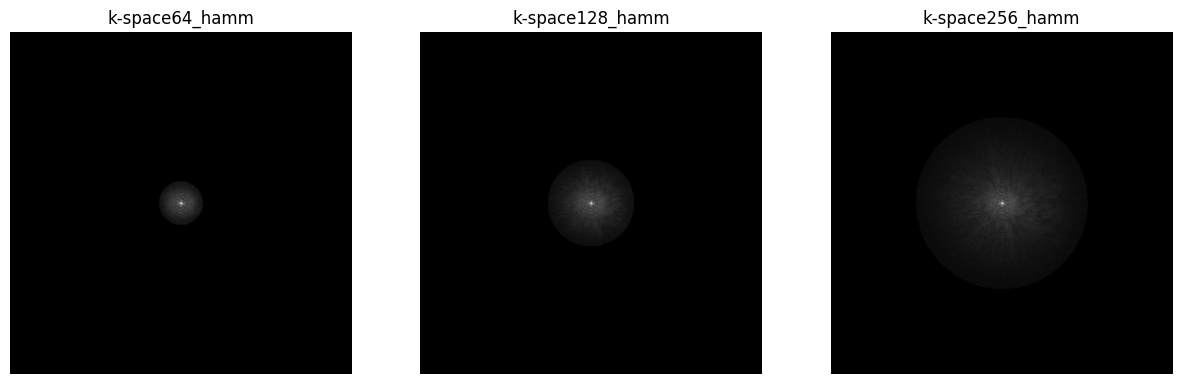

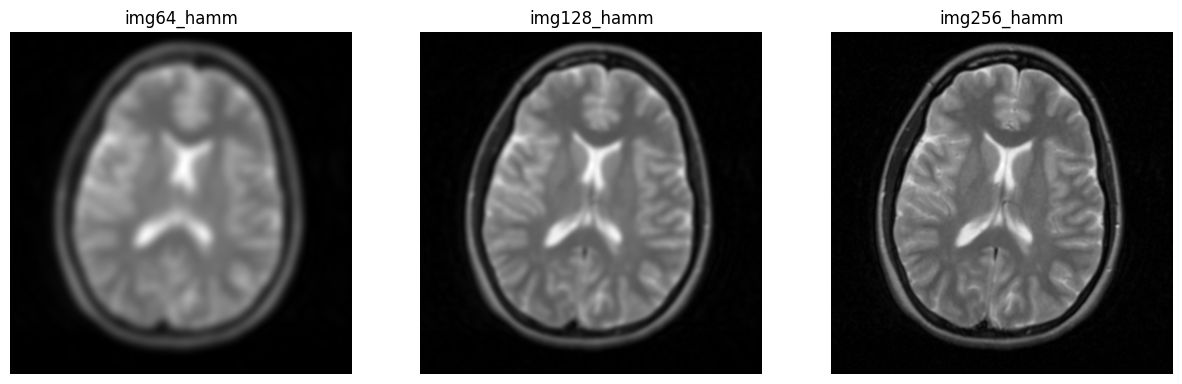

In [14]:
# Your code here ...
# kspace difference: hamming window is smoother at the edge and round, shows less gibbs artifacts
kdata64_hamm = masking(kdata, 64, "hamming")
kdata128_hamm = masking(kdata, 128, "hamming")
kdata256_hamm = masking(kdata, 256, "hamming")

recon_img64_hamm = ifft2c(kdata64_hamm)
recon_img128_hamm = ifft2c(kdata128_hamm)
recon_img256_hamm = ifft2c(kdata256_hamm)

utils.imshow([kdata64_hamm, kdata128_hamm, kdata256_hamm], titles=["k-space64_hamm", "k-space128_hamm", "k-space256_hamm"], norm=0.3)
utils.imshow([recon_img64_hamm, recon_img128_hamm, recon_img256_hamm], titles=["img64_hamm", "img128_hamm", "img256_hamm"])

Compare the reconstructed images between Rectangular and Hamming windowing

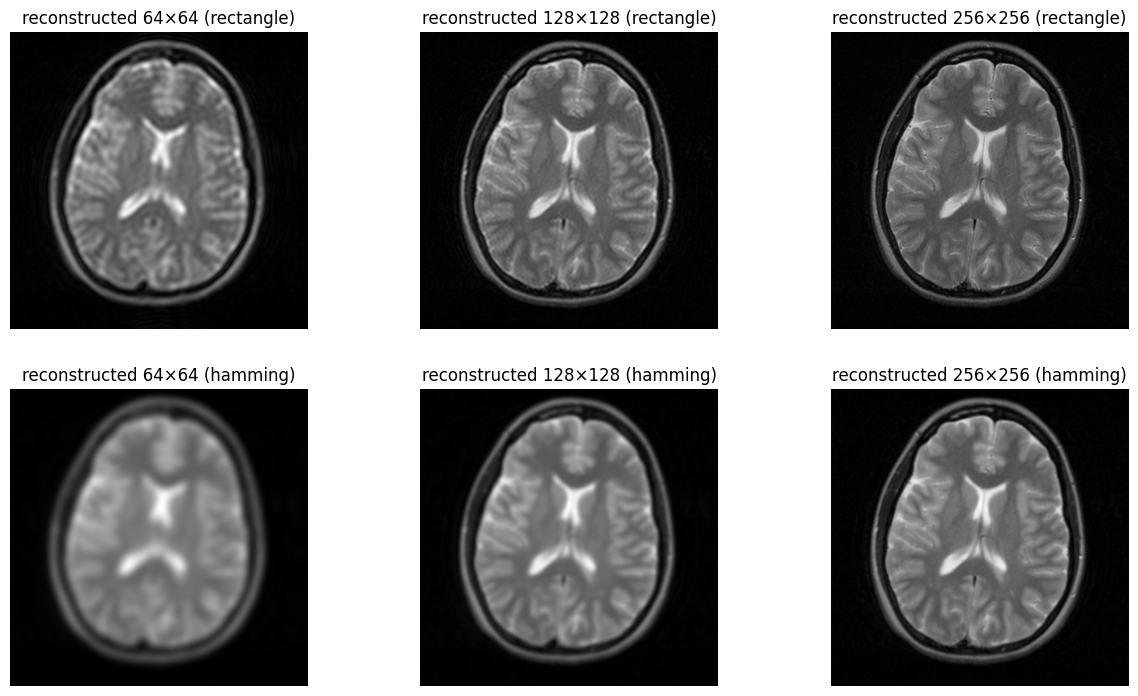

In [15]:
# Your code here ...
# hamm remove the ringing artifacts but reduce the resolution (blur)
# why use the rectangle, and the properties of rectangle filter
# why use the hamming, and the properties of hamming filter
recon_rectangles = [recon_img64, recon_img128, recon_img256]
recon_hamming = [recon_img64_hamm, recon_img128_hamm, recon_img256_hamm]
recon_rect_titles = ["reconstructed 64×64 (rectangle)", "reconstructed 128×128 (rectangle)", "reconstructed 256×256 (rectangle)"]
recon_hamm_titles = ["reconstructed 64×64 (hamming)", "reconstructed 128×128 (hamming)", "reconstructed 256×256 (hamming)"]
utils.imshow(recon_rectangles + recon_hamming, titles=(recon_rect_titles + recon_hamm_titles), num_rows=2)

- Compute the PSF along the x-dimension for each window and compare it to the PSF from part 3, where a rectangular window was implicitly used for the reconstruction.

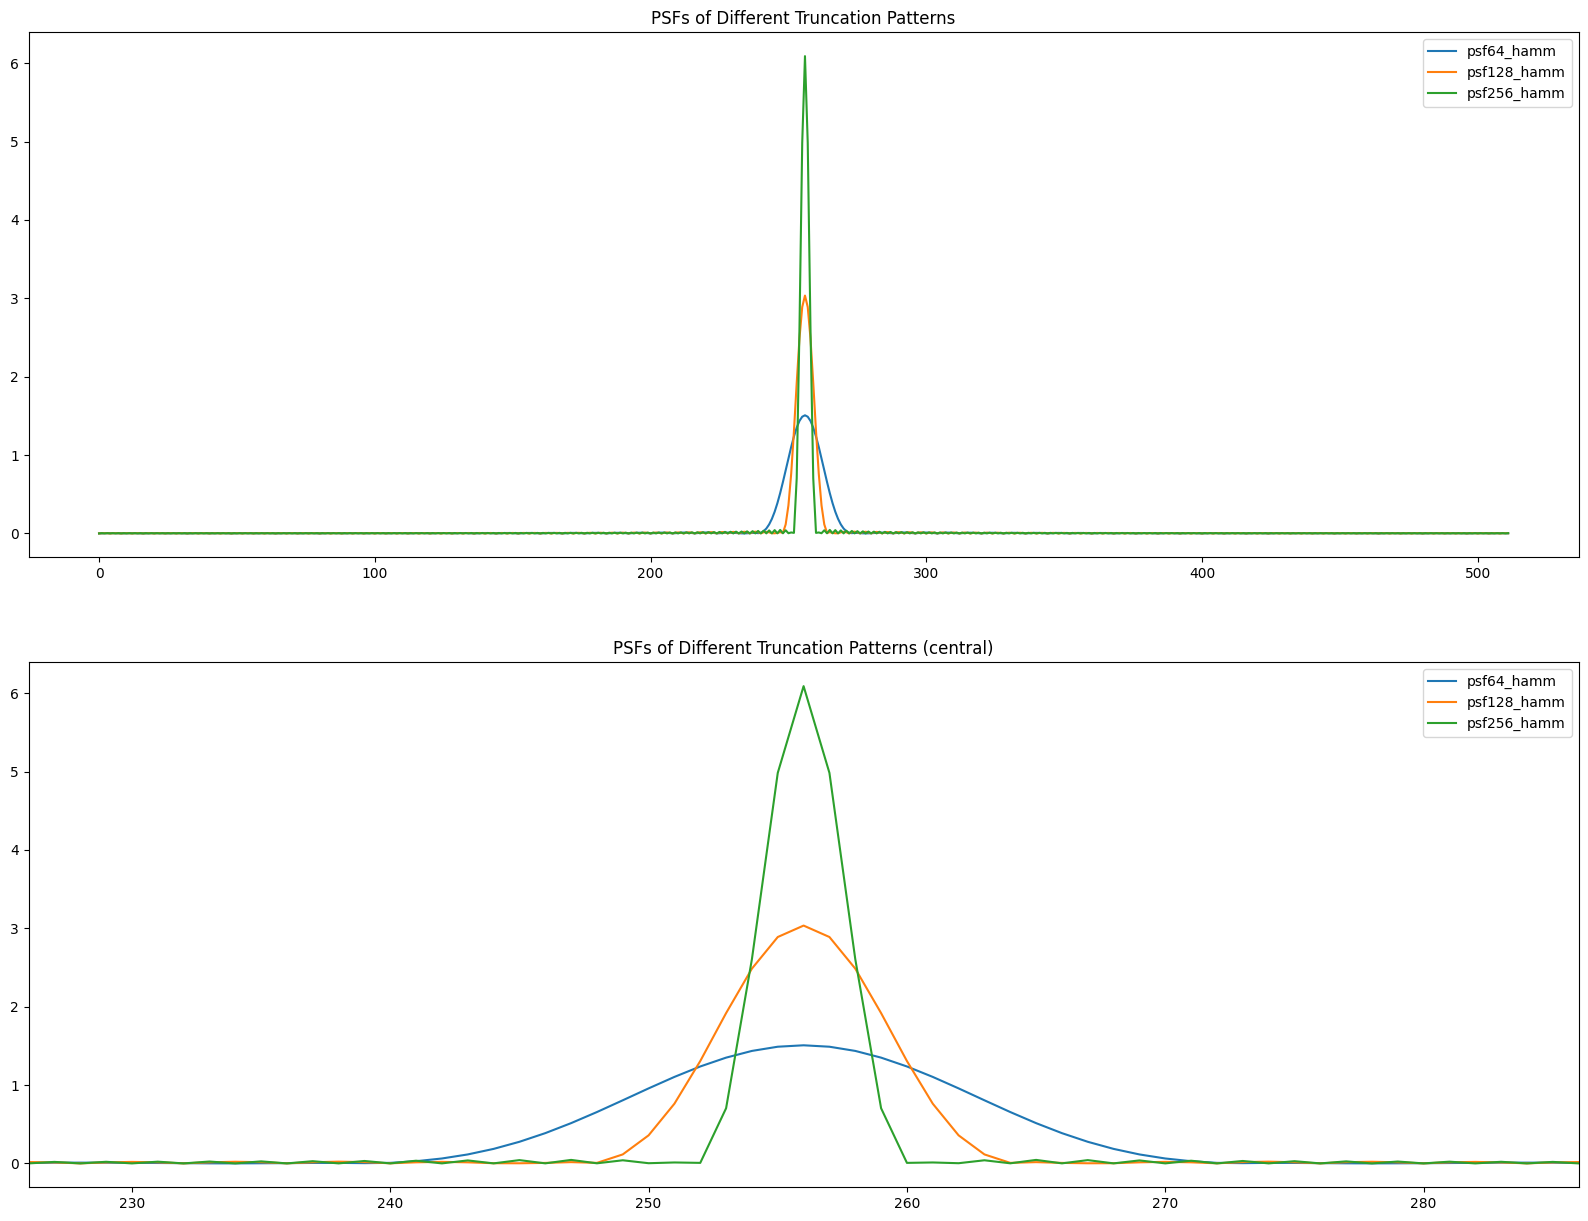

In [16]:
# Your code here ...
psf64_hamm = get_psf([kdata64_hamm.shape[0], 64], "Hamming")
psf128_hamm = get_psf([kdata128_hamm.shape[0], 128], "Hamming")
psf256_hamm = get_psf([kdata256_hamm.shape[0], 256], "Hamming")

plt.subplot(211)
for psf, label in zip([psf64_hamm, psf128_hamm, psf256_hamm], ["psf64_hamm", "psf128_hamm", "psf256_hamm"]):
    plt.plot(psf, label=label)
plt.legend()
plt.title("PSFs of Different Truncation Patterns")

plt.subplot(212)
for psf, label in zip([psf64_hamm, psf128_hamm, psf256_hamm], ["psf64_hamm", "psf128_hamm", "psf256_hamm"]):
    plt.plot(psf, label=label)
plt.legend()
plt.xlim(256 - 30, 256 + 30)
plt.title("PSFs of Different Truncation Patterns (central)")

figure = plt.gcf()
figure.set_size_inches(20, 15)
plt.show()

- Compute and compare the FWHM of the PSF of the Hamming window and again compare it to the rectangular window from part 3.


In [17]:
# Your code here ...
fwhm64_hamm = get_fwhm(psf64_hamm)
fwhm128_hamm = get_fwhm(psf128_hamm)
fwhm256_hamm = get_fwhm(psf256_hamm)

print(f"FWHM for 64 (hamming): {fwhm64_hamm}")
print(f"FWHM for 128 (hamming): {fwhm128_hamm}")
print(f"FWHM for 256 (hamming): {fwhm256_hamm}")

FWHM for 64 (hamming): 14
FWHM for 128 (hamming): 8
FWHM for 256 (hamming): 4


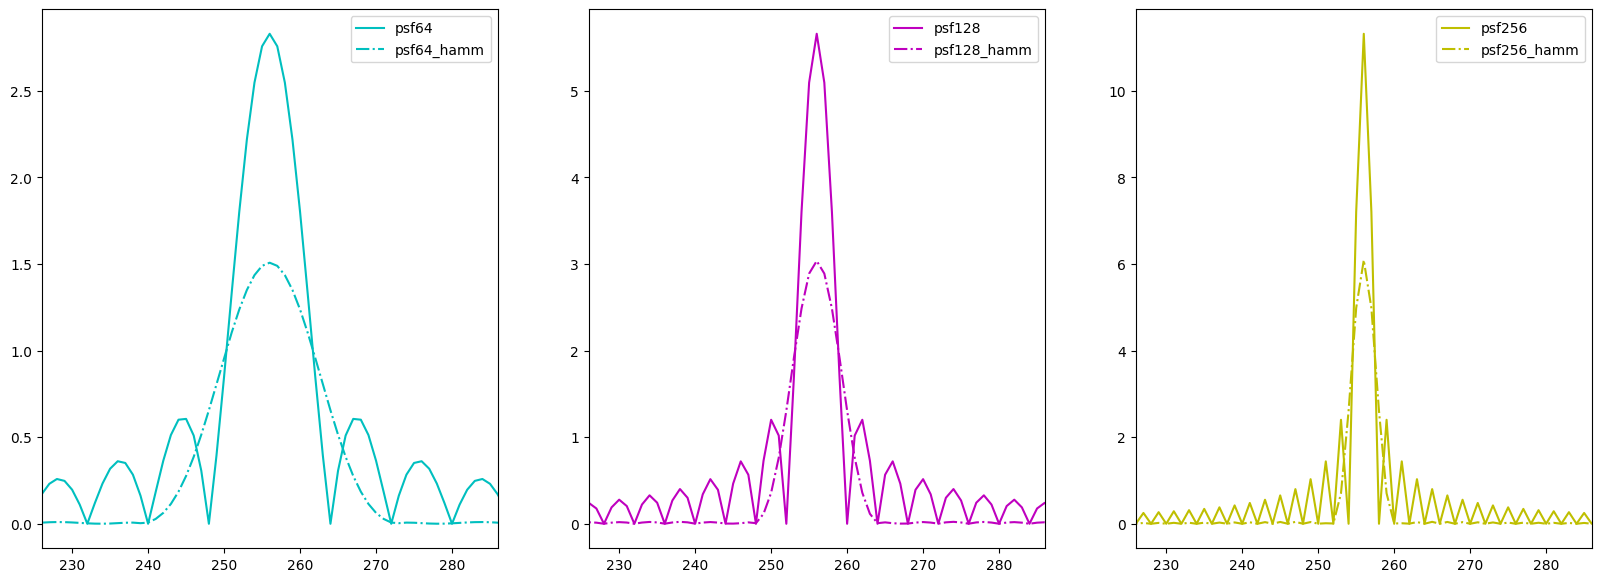

In [119]:
# Your code here ...
# hamming: side lod disappears
psf_group = [[psf64, psf128, psf256], [psf64_hamm, psf128_hamm, psf256_hamm]]
legend_group = [["psf64", "psf128", "psf256"], ["psf64_hamm", "psf128_hamm", "psf256_hamm"]]
lines = ['-', '-.']
colors = ['c', 'm', 'y']
f, ax = plt.subplots(1, 3)
f.set_size_inches(20, 7)
for psfs, legends, line in zip(psf_group, legend_group, lines):
    for i, (psf, legend, color) in enumerate(zip(psfs, legends, colors)):
        ax[i].plot(abs(psf), linestyle=line, label=legend, c=color)
        ax[i].set_xlim(256 - 30, 256 + 30)
        ax[i].legend()
plt.show()

- Discuss advantages and disadvantages of the different windows with respect to each other, in particular the effects on resolution and Gibbs ringing. Hint: Take a look at the sidelobes of the PSF.



## 5. Oversampling the Readout Dimension:

- Load the file `kdata2.mat`. The k-space data has dimensions [168, 336]. The frequency-encoding dimension (second dimension) was oversampled by a factor of 2.


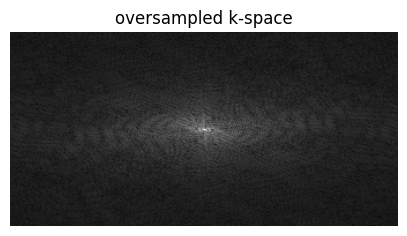

In [120]:
mat = utils.load_data('kdata2.mat')
ovs_kdata = mat['kdata2']
# x is the readout direction
utils.imshow([ovs_kdata], titles=["oversampled k-space"], norm=0.3)

- Reconstruct an oversampled image

In [121]:
# Your code here ...
ovs_recon_img = ifft2c(ovs_kdata)
# sampled with the whole width, 2 times of oversampled

- Remove the oversampling by decimating the frequency-encoding dimension.

In [122]:
# Your code here ...
ovs_rate = 2
_, oversampled_ro = ovs_recon_img.shape
original_size = oversampled_ro // ovs_rate
decimated_img = ovs_recon_img[:, oversampled_ro//2 - original_size // 2: oversampled_ro//2 + original_size // 2]

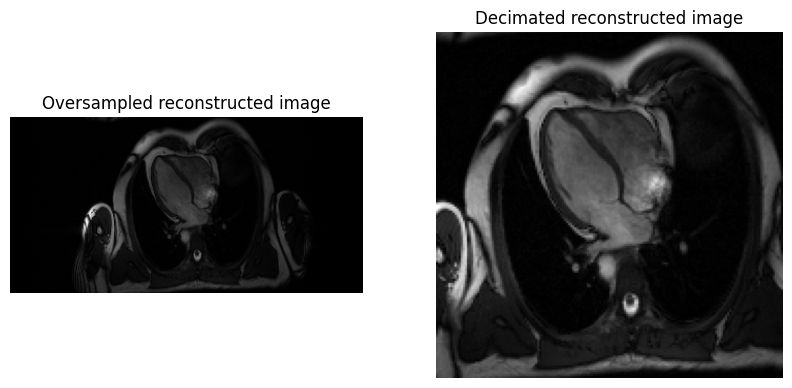

In [124]:
# Your code here ...
# more samples, side lods reduced, reduce...
utils.imshow([ovs_recon_img, decimated_img], titles=["Oversampled reconstructed image", "Decimated reconstructed image"])

- Discuss the effect of oversampling.